# Анализ продаж аптечной сети

Проведём слеующий анализ:
- Анализ бонусной программы и лояльности клиентов
    * зависимость между суммой чека и долей потраченных бонусов
    * средний чек по магазину при использовании бонусов и средний чек без их использования
    * активность начисления бонусов по месяцам года
- Анализ продаж и ценовой политики
    * средний чек в будни и выходные
    * распределение сумм чеков нормально 
- Эффективность сотрудников
    * средний чек не различается между сотрудниками     
- Сравнение каналов и форматов продаж
    * средний чек онлайн-заказов и средний чек офлайн-покупок
    * структура корзины (кол-во позиций) для онлайн и офлайн заказов

Выводы будут полезны специалистам по маркетингу, коммерческому директору.


[Структура таблиц БД apteka](tables.md)

In [51]:
# 1. Методы

import pandas as pd
import configparser
import psycopg2
from scipy.stats import *
from statsmodels.stats.diagnostic import lilliefors
import matplotlib.pyplot as plt
import numpy as np
import scikit_posthocs as sp
import seaborn as sns 

def load_config(filename='config.ini', section='Database'):
    parser = configparser.ConfigParser()
    parser.optionxform = str 
    parser.read(filename)   
    # считываем секцию, секция по умолчанию Database
    config = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            config[param[0]] = param[1]
    else:
        raise Exception('Секция {0} не найдена в файле {1} '.format(section, filename))
    return config

class DataBase:
    __instance = None
    connection = None
    def __new__(cls, *args, **kwargs):
        if not cls.__instance:
            cls.__instance = super().__new__(cls)
        return cls.__instance
            
    def __init__(self, **params): # host, port, database, user, password, autocommit=False):
        self.connection = psycopg2.connect(
            host=params['host'],
            port=params['port'],
            database=params['database'],
            user=params['user'],
            password=params['password'],
        )
        DataBase.__instance = self    
        if params['autocommit'].strip().lower() == 'true':
            self.connection.autocommit = True   
        self.cursor = self.connection.cursor()      

    @classmethod
    def get_instance(cls):
        if cls.__instance is None :    
            cls.__instance = super().__new__(cls)
        else:
            return cls.__instance    
        return cls.__instance           
     
    def close_connection(self):
        if self.connection:
            try:
                self.cursor.close()
            except:
                pass    
            self.connection.close()  
        DataBase.__instance = None

    def select(self, query, vars=None, cursor_factory = None):          
        if cursor_factory:
            self.cursor.close()
            self.cursor = self.connection.cursor(cursor_factory=cursor_factory)
        self.cursor.execute(query, vars)
        rs = self.cursor.fetchall()
        return rs

In [3]:
# 2. Считываем параметры подключения к БД
db_config = load_config()

# Гипотеза 1.
- H0: Нет корреляции между суммой чека (summ) и долей потраченных бонусов (bonus_spent)

Используем таблицу bonuscheques

In [35]:

# Гипотеза 1.

# запрос к БД
sql_query = """
    select 
	    bonus_spent -- количество потраченных бонусов
	    ,summ       -- сумма чека
    from bonuscheques b
    where b.bonus_spent > 0
  """

# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query)
        column_names = [desc[0] for desc in db.cursor.description]
        df1 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    db.close_connection()


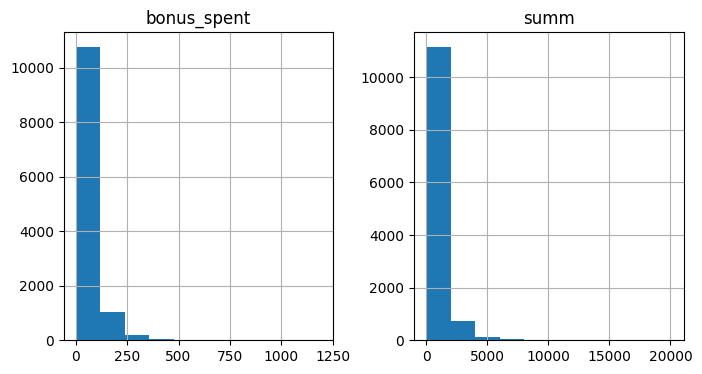

In [36]:
# посмотрим на форму распределения
df1.hist(column=['bonus_spent', 'summ'],bins=10, figsize=(8, 4));


In [40]:
# Данные не распределены нормально - применим корреляцию Спирмена
r1 = spearmanr(df1['bonus_spent'], df1['summ'])

print(f'statistic = {r1.statistic}, p-value = {r1.pvalue}')
print(f'Гипотезу о независимсоти суммы чека и долей потраченных бонусов {"принимаем." if r1.pvalue>0.05 else "отклоняем." }')

# Слабая положительная связь

statistic = 0.26442755174621724, p-value = 2.0467962229386555e-192
Гипотезу о независимсоти суммы чека и долей потраченных бонусов отклоняем.


In [41]:
# посчитаем коэффициент использования бонусов в зависимости от суммы чека
# разобъём интервал на 5 групп

df1['grp'] = pd.qcut(df1['summ'], q=5, labels = ['g1','g2','g3','g4','g5'])
# добавим колонку с классификацией - разобъём на 5 интервалов и посмотрим какоё % бонусов тратится в каждой группе
grouped = df1.groupby('grp', observed=False).agg( bc = ('bonus_spent', 'count'),
                       bs = ('bonus_spent', 'sum'),
                       summ = ('bonus_spent', 'mean')
)
grouped['k'] = grouped['summ'] / grouped['bs'] * 1e6

grouped[['k']]


,k
grp,
g1,411.692054
g2,415.973378
g3,412.201154
g4,415.627598
g5,413.907285


Выводы:
- Обнаружена слабая положительная связь между суммой чека и долей потраченных бонусов. 
- Доля потраченных бонусов практически не зависит от суммы чека.
- Возможно стоит пересмотреть программу лояльности для стимулирования более крупных покупок через бонусы.


# Гипотеза 2.
- H0: Средний чек по магазину при использовании бонусов = средний чек без их использования

Используем таблицу bonuscheques

In [42]:
# Гипотеза 2.


sql_query = """
    select 
        shop -- магазин
        ,round(avg(summ) filter (where bonus_spent>0) , 2) as avcq_w_b  -- средний чек при использовании бонусов
        ,round(avg(summ) filter (where bonus_spent=0) , 2) as avcq_wo_b -- средний чек без использования бонусов
        from bonuscheques
    group by 1
    order by substr(shop, strpos(shop, ' ') + 1, length(shop))::int
"""

# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query)
        column_names = [desc[0] for desc in db.cursor.description]
        df2 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    db.close_connection()

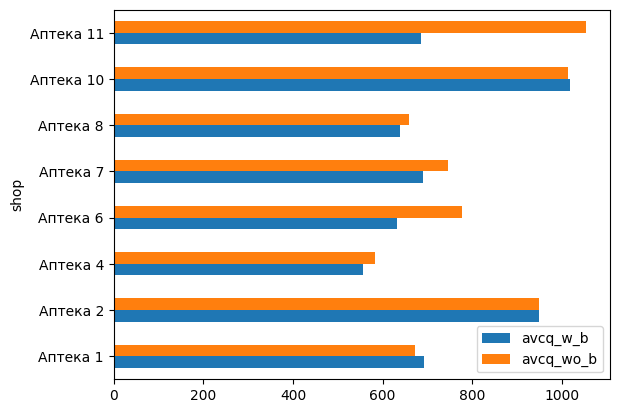

In [43]:
# Графическое представление
df2['avcq_w_b'] = pd.to_numeric(df2['avcq_w_b'])
df2['avcq_wo_b'] = pd.to_numeric(df2['avcq_wo_b'])

df2.plot(kind = 'barh', x='shop', y=['avcq_w_b','avcq_wo_b']);


In [46]:
sampl1 = np.array(df2['avcq_w_b'].values, dtype=float)
sampl2 = np.array(df2['avcq_wo_b'].values, dtype=float) 

# Применим метод Уилкоксона
statistic, pvalue = wilcoxon(sampl1, sampl2)

print(f'p-value = {pvalue}')
print(f'Гипотезу: Средний чек при использовании бонусов = средний чек без их использования {"принимаем." if pvalue>0.05 else "отклоняем." }')
# WilcoxonResult(statistic=5.0, pvalue=0.078125)

# принимаем 0 гипотезу

p-value = 0.078125
Гипотезу: Средний чек при использовании бонусов = средний чек без их использования принимаем.


Выводы:
- наблюдается равенство среднего чека в не зависимости от использования бонусов и магазина
- текущая бонусная программа не стимулирует покупателя к увеличению суммы покупки, но возможно таким образом работает на удержание, поведение покупателей предсказуемо.
- бонусы воспринимаются покупателем как удобный способ оплаты.
- если есть цель на увеличение среднего чека, то надо пересмотреть бонусную программу.

# Гипотеза 3

- H0: Активность начисления бонусов одинакова во все месяцы года 

Используем таблицу bonuscheques

In [47]:
# Гипотеза 3.

sql_query1 = """
select 
    to_char(datetime, 'MM')::integer as month  -- номер месяца
    ,(bonus_earned) as bonus_earned  --начисленные бонусы
from bonuscheques b
"""

sql_query2 = """
select 
    to_char(datetime, 'MM')::integer as month,    -- номер месяца
    count(distinct card) as active_cards,         -- уникальные активные карты
    count(distinct doc_id) as transactions_count, -- количество чеков
    sum(bonus_earned) as total_bonuses_earned,    -- начисленные бонусы
    avg(bonus_earned) as avg_bonuses_per_check,   -- среднее количество бонусов на чек
    sum(summ) as total_revenue,                   -- общая выручка
    sum(summ_with_disc) as net_revenue,           -- выручка с учётом скидок
    round(sum(bonus_earned) * 1.0 / nullif(sum(summ), 0), 4) as accrual_rate  -- бонусы на 1 рубль
from bonuscheques
group by  1
order by month;
"""

# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query1)
        column_names = [desc[0] for desc in db.cursor.description]
        df31 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    try:
        data = db.select(sql_query2)
        column_names = [desc[0] for desc in db.cursor.description]
        df32 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')        
    db.close_connection()

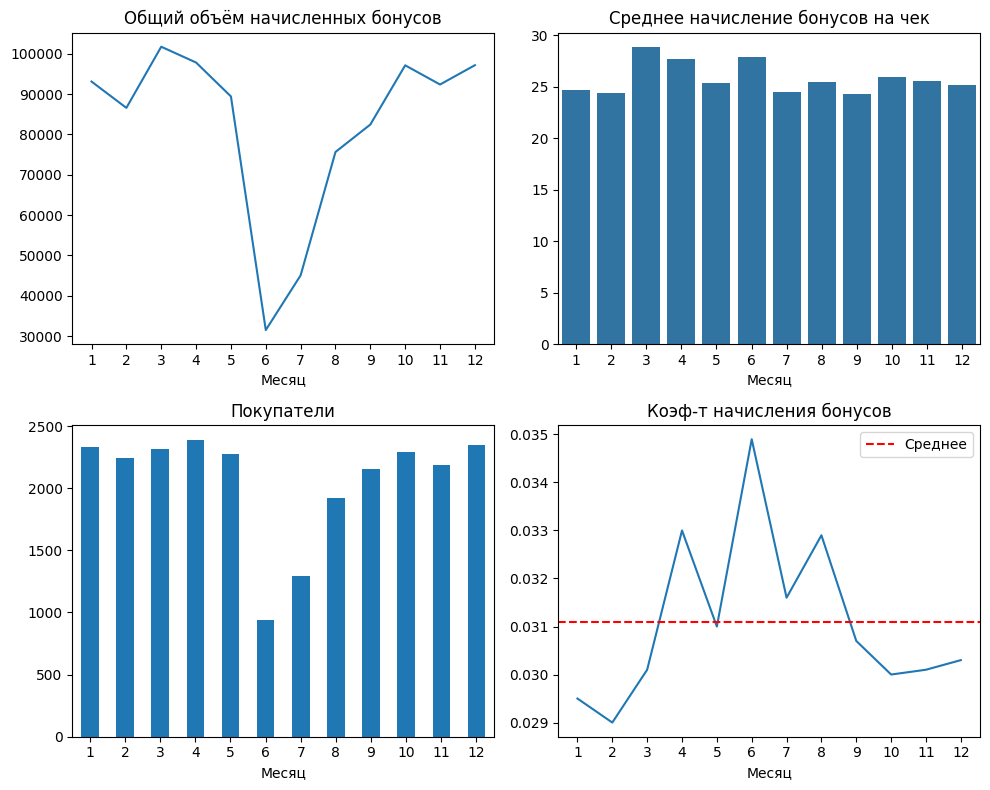

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# 1. Динамика начисленных бонусов по месяцам
sns.lineplot(data=df32[['month','total_bonuses_earned']], x='month', y='total_bonuses_earned', ax=ax[0,0])
ax[0,0].tick_params(axis='x')
ax[0,0].set_xticks(df32['month'].unique()) # отобразить все метки
ax[0,0].set_xlabel('Месяц')
ax[0,0].set_ylabel('')
ax[0,0].set_title('Общий объём начисленных бонусов')

# 2. Усреднённая сезонность 
sns.barplot(data=df32[['month','avg_bonuses_per_check']], x='month', y='avg_bonuses_per_check', ax=ax[0,1])
ax[0,1].set_xlabel('Месяц')
ax[0,1].set_ylabel('')
ax[0,1].set_title('Среднее начисление бонусов на чек')

# 3. Активность клиентов по месяцам
df32[['month','active_cards']].plot(kind='bar',x= 'month', y='active_cards', ax=ax[1,0], legend=False)
ax[1,0].tick_params(axis='x', rotation=0)
ax[1,0].set_xlabel('Месяц')
ax[1,0].set_title('Покупатели')

# 4. Коэффициент начисления (бонусы / выручка)
sns.lineplot(data=df32[['month','accrual_rate']], x='month', y='accrual_rate', ax=ax[1,1])  
ax[1,1].axhline(y=df32['accrual_rate'].mean(), color='red', linestyle='--', label='Среднее')
ax[1,1].set_xticks(df32['month'].unique()) # отобразить все метки
ax[1,1].set_xlabel('Месяц')
ax[1,1].set_ylabel('')
ax[1,1].set_title('Коэф-т начисления бонусов')
ax[1,1].legend()

plt.tight_layout()
plt.show()

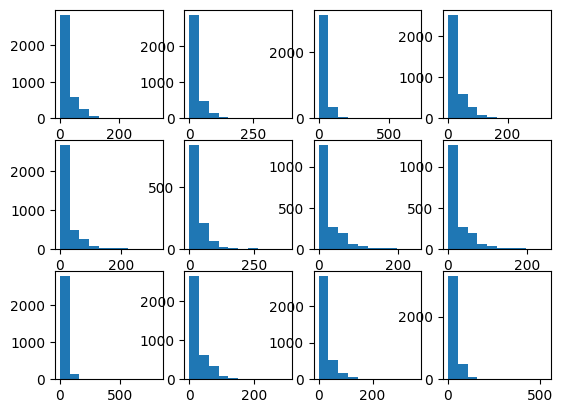

In [55]:
# формируем выборки по месяцам
series = [v["bonus_earned"].values for _, v in df31.groupby("month")[["bonus_earned"]]]

# Посмотрим на распределения

from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 4)
ax[0, 0].hist(series[0]);
ax[0, 1].hist(series[1]);
ax[0, 2].hist(series[2]);
ax[0, 3].hist(series[3]);
ax[1, 0].hist(series[4]);
ax[1, 1].hist(series[5]);
ax[1, 2].hist(series[6]);
ax[1, 3].hist(series[6]);
ax[2, 0].hist(series[7]);
ax[2, 1].hist(series[9]);
ax[2, 2].hist(series[10]);
ax[2, 3].hist(series[11]);

plt.show();

In [53]:
# Проверка нормальности (по месяцам)
# norm_tests = [shapiro(s).pvalue for s in series]
norm_tests = [lilliefors(s, dist='norm')[1] for s in series]

# print(f"Нормальность (p-values): {norm_tests}")
# print(f"Нормальность (p-values): {norm_tests}")

if all(p > 0.05 for p in norm_tests):     # Если p > 0.05 по всем месяцам то можно использовать ANOVA
    print("Данные имеют нормальное распределение, применим метод ANOVA")
    stat, p_value = f_oneway(*series)
    print(f"  ANOVA: F={stat:.3f}, p={p_value:.4f}")
else:
    print("Данные не нормальны, применим критерий Краскела-Уоллиса")
    stat, p_value = kruskal(*series)
    print(f"  Kruskal-Wallis: statistics={stat:.3f}, p-value={p_value:.4f}")

if p_value < 0.05:
    print("Есть статистически значимые различия в распределении бонусов по месяцам")
else:
    print("Различия в распределении бонусов по месяцам незначимы")    
print(f'Гипотезу что активность начисления бонусов одинакова во все месяцы года {"принимаем." if p_value>0.05 else "отклоняем." }')

# Данные не нормальны, применим метод Краскела-Уоллиса
#   Kruskal-Wallis: statistics=27.852, p-value=0.0034
# Есть статистически значимые различия в распределении бонусов по месяцам

Данные не нормальны, применим критерий Краскела-Уоллиса
  Kruskal-Wallis: statistics=83.235, p-value=0.0000
Есть статистически значимые различия в распределении бонусов по месяцам
Гипотезу что активность начисления бонусов одинакова во все месяцы года отклоняем.


     1         2         3         4         5    6         7    8         9   \
1   1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.000000   
2   1.0  1.000000  0.810367  0.811410  1.000000  1.0  1.000000  1.0  1.000000   
3   1.0  0.810367  1.000000  1.000000  0.800088  1.0  0.526235  1.0  0.306867   
4   1.0  0.811410  1.000000  1.000000  0.810367  1.0  0.531572  1.0  0.312413   
5   1.0  1.000000  0.800088  0.810367  1.000000  1.0  1.000000  1.0  1.000000   
6   1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.000000   
7   1.0  1.000000  0.526235  0.531572  1.000000  1.0  1.000000  1.0  1.000000   
8   1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.000000   
9   1.0  1.000000  0.306867  0.312413  1.000000  1.0  1.000000  1.0  1.000000   
10  1.0  0.557901  1.000000  1.000000  0.545655  1.0  0.376968  1.0  0.193527   
11  1.0  1.000000  1.000000  1.000000  1.000000  1.0  1.000000  1.0  1.000000   
12  1.0  1.000000  1.000000 

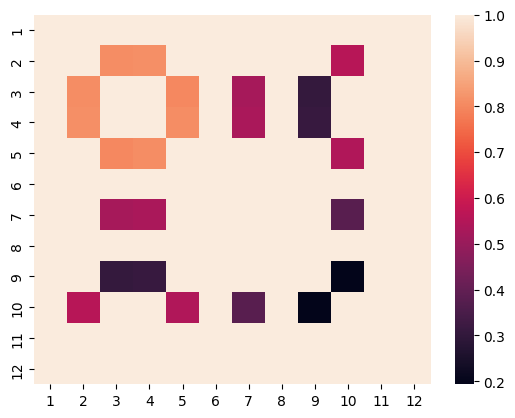

In [57]:
# Посмотрим между какими месяцами различие
# Проведём тест множественного сравнения - критерий Данна

res3 = sp.posthoc_dunn(series, p_adjust = 'holm') # 'bonferroni')  
print(res3)

# r3 = (res3 > 0.20)
# print(r3)

#  визуализация
sns.heatmap(res3);
plt.show()



Выводы:
- Наблюдается спад продаж летом (снижение трафика/спроса), стимулировать летние категории товаров. Повышенное начисление бонусов на покупку в летний период не компенсирует падения продаж.
- В остальные периоды фокус на удержание

# Гипотеза 4

- H0: Средний чек в будние дни равен среднему чеку в выходные 

Используем таблицу sales

In [60]:
# Гипотеза  4.

sql_query = """
with by_wd as (
select 
	dr_apt || '-' || dr_nchk || '-' || dr_dat as cq_num,  -- номер чека
	dr_apt,                                               -- код аптеки
	dr_dat,                                               -- дата чека
	extract(isodow from dr_dat) as dow,                   -- номер деня недели
    case when extract(isodow from dr_dat) <6 then 'wd' else 'we' end as wd  -- будни или выходные
	,sum(DR_Kol*DR_CRoz - DR_SDisc) as cq_summ             -- сумма чека
from sales s 	
where DR_Kol > 0
group by 1, 2, 3, 4, 5
having sum(DR_Kol*DR_CRoz - DR_SDisc) > 0
)
select * from by_wd
"""

# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query)
        column_names = [desc[0] for desc in db.cursor.description]
        df4 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    # закрытие соединения с базой
    db.close_connection()

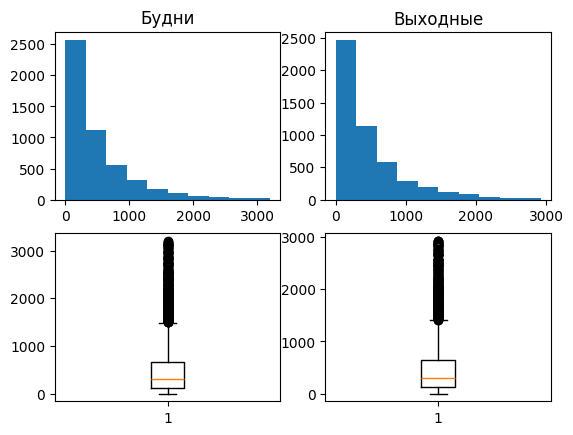

In [63]:
# формируем выборки
series = [v['cq_summ'].values for _, v in df4.groupby('wd')[['cq_summ']] ]

# избавимся от выбросов
c_ser = []

for s in series:
    up_l = s.mean() + 3 * s.std()
    low_l = s.mean() - 3 * s.std()
    c_ser.append(s[(s < up_l) & (s > low_l)])


# выберем не более 5000 значений из каждого ряда
ln = min(c_ser[0].size, c_ser[1].size)
ln = 5000 if ln > 5000 else ln

rng = np.random.default_rng(seed=42)

for i in range(len(c_ser)):
    c_ser[i] = rng.choice(c_ser[i], size = ln, replace=False)


fig, ax = plt.subplots(2, 2)
ax[0, 0].set_title("Будни")
ax[0, 0].hist(c_ser[0])
ax[0, 1].set_title("Выходные")
ax[0, 1].hist(c_ser[1])
ax[1, 0].boxplot(c_ser[0])
ax[1, 1].boxplot(c_ser[1])
plt.show();

In [64]:
# проверка на нормальность

pvalue_wd = shapiro(c_ser[0]).pvalue
pvalue_we = shapiro(c_ser[1]).pvalue

# выберем метод
if pvalue_we > 0.05 and pvalue_wd > 0.05:
    print('Нормальное распределение')
    r4 = ttest_ind(c_ser[0], c_ser[1])
    print(f'  T-тест: statistics={r4.statistic}, p-value={r4.pvalue}')
else:
    print('Не нормальное распределение')
    r4 = mannwhitneyu(c_ser[0], c_ser[1])
    print(f'  Mann-Whitney: statistics={r4.statistic}, p-value={r4.pvalue}')

print(f'Гипотезу: Средний чек в будние = средний чек в выходные {"принимаем." if r4.pvalue>0.05 else "отклоняем. " }')

print(f"Медиана: будни - {np.median(c_ser[0]):.2f}, выходные - {np.median(c_ser[1]):.2f}")
print(f"Межквартильный размах будни: {np.quantile(c_ser[0], 0.75) - np.quantile(c_ser[0], 0.25):.2f}, выходные: {np.quantile(c_ser[1], 0.75) - np.quantile(c_ser[1], 0.25):.2f}")

Не нормальное распределение
  Mann-Whitney: statistics=12689577.5, p-value=0.18906036630858325
Гипотезу: Средний чек в будние = средний чек в выходные принимаем.
Медиана: будни - 307.00, выходные - 297.50
Межквартильный размах будни: 541.68, выходные: 515.25


In [67]:
# стркутура продаж по дням недели
df4.groupby('dow')['cq_summ'].agg({'mean', 'count'})

,mean,count
dow,,
1.0,574.313428,2804
2.0,570.809365,3310
3.0,623.855796,3393
4.0,587.910259,3249
5.0,598.905362,2825
6.0,556.073864,2532
7.0,558.888048,2820


Выводы:
- стабильный спрос на товары
- возможно имеет смысл увеличить продажи премиум товаров в ыходные дни и возможно пересмотреть бонусную программу (требуется более глубокий анализ но нехватает данных)


# Гипотеза 5

- H0: Распределение сумм чеков нормально

Используем таблицу sales

In [68]:
# Гипотеза 5.

sql_query = """
select 
	sum(DR_Kol*DR_CRoz - DR_SDisc) as cq_summ  -- сумма чека
from sales s 	
where dr_kol >0
group by dr_apt || '-' || dr_nchk || '-' || dr_dat
"""

# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query)
        column_names = [desc[0] for desc in db.cursor.description]
        df5 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    # закрытие соединения с базой
    db.close_connection()

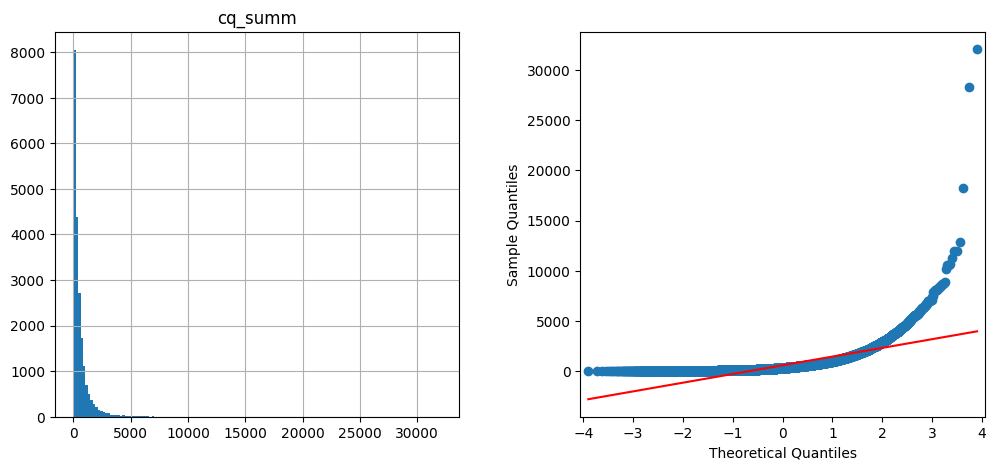

In [69]:
# Посмотрим на форму и построим qq-plot

from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(1, 2, figsize=(12,5))

df5.hist(bins=150, ax=ax[0]);

qqplot(df5['cq_summ'], line='s', ax = ax[1] )

plt.show()

In [70]:
# тест на нормальность распределения

size = len(df5)
print(f'Размер выборки {size}, применяем метод {'Колмогорова - Смирнова ' if size > 20000 else 'Шапиро - Уилка'}')

mean = df5['cq_summ'].mean()
std = df5['cq_summ'].std()

# проводим тест
if size > 20000:
    r5 = kstest(df5['cq_summ'], 'norm', args=(mean, std))
else:
    r5 = shapiro(df5['cq_summ'])

print(r5)
print(f'p-value = {r5.pvalue}')
# отвергаем нулевую гипотезу
print(f'Гипотезу: Распределение сумм чеков нормально {"принимаем." if r5.pvalue>0.05 else "отклоняем." }')

Размер выборки 20933, применяем метод Колмогорова - Смирнова 
KstestResult(statistic=0.2515635865871552, pvalue=0.0, statistic_location=12.8, statistic_sign=-1)
p-value = 0.0
Гипотезу: Распределение сумм чеков нормально отклоняем.


In [71]:
# Числовые характеристики
print(f"Среднее: {df5['cq_summ'].mean():.2f}")
print(f"Медиана: {df5['cq_summ'].median():.2f}")
print(f"Skewness: {df5['cq_summ'].skew():.2f} (>0 = правосторонняя асимметрия)")


Среднее: 582.93
Медиана: 316.00
Skewness: 7.67 (>0 = правосторонняя асимметрия)


Выводы:
- Большинство покупок небольшие - (мадиана меньше среднего), но есть крупные чеки
- Есть правый хвост, возможно выделение VIP клиентов
- потенциал увеличения продаж в фокусе VIP клиентов


# Гипотеза 6

- H0: Средний чек не различается между сотрудниками

Используем таблицу sales

In [72]:
# Гипотеза 6.

sql_query = """
with sbe as (
select 
	DR_TabEmpl,                             --  табельный номер сотрудника
    dr_nchk,
    sum(DR_Kol*DR_CRoz - DR_SDisc) cq_sum   --  сумма чека
from sales
where dr_kol >0
group by dr_apt || '-' || dr_nchk || '-' || dr_dat, DR_TabEmpl, dr_nchk
order by 1
),
empl as (
select DR_TabEmpl,                         --  табельный номер сотрудника
    count(DR_TabEmpl) as cnt               --  кол-во чеков
from sbe 
group by 1 having(count(DR_TabEmpl)) > 300  -- отсекаем сотрудников которые редко продавали (возможно новые сотрудники)
)
select * from sbe where sbe.DR_tabempl in (select dr_tabempl from empl) order by 1
"""

# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query)
        column_names = [desc[0] for desc in db.cursor.description]
        df6 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    # закрытие соединения с базой
    db.close_connection()

In [75]:

tabnums = df6['dr_tabempl'].unique()

samples = []

for tn in tabnums:
    samples.append(df6[df6['dr_tabempl'] == tn]['cq_sum'].values)
# samples = [df6['cq_sum'].values for _, v in df6.groupby('dr_tabempl')[['cq_sum']]]    

# используем критерий Краскела - Уоллиса
r6 = kruskal(*samples)

print(f'тест Краскела-Уоллиса: statistic = {r6.statistic}, p-value = {r6.pvalue}')
# отвергаем нулевую гипотезу
print(f'Гипотезу: Средний чек не различается между сотрудниками {"принимаем." if r6.pvalue>0.05 else "отклоняем." }')

тест Краскела-Уоллиса: statistic = 519.8186959257963, p-value = 7.0693969969370445e-99
Гипотезу: Средний чек не различается между сотрудниками отклоняем.


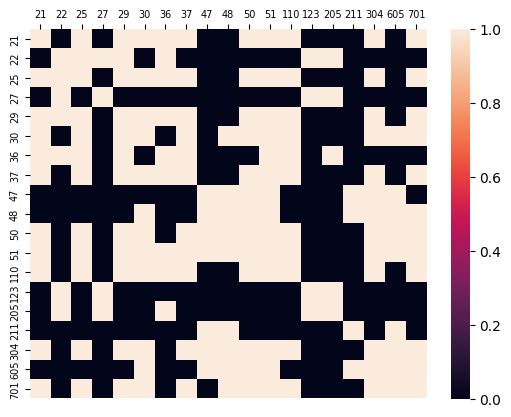

In [76]:
# Средний чек каких сотрудников отличается - критерий Данна

import scikit_posthocs as sp

res6 = sp.posthoc_dunn(samples, p_adjust = 'bonferroni')

hm6 = (res6 > 0.05) 

ax = sns.heatmap(hm6);
ax.xaxis.set_ticks_position('top');
ax.set_xticklabels(tabnums, fontsize=7);
ax.set_yticklabels(tabnums, fontsize=7);

# Гипотеза 7

- H0: Средний чек онлайн-заказов (DR_VZak = 2) = офлайн-покупок (DR_VZak = 1)
    * DR_VZak - вид закупки (1 - обычный, 2 - интернет-заказ)

Используем таблицу sales

In [77]:
# 7

sql_query = """
with sls as (
select 
	dr_apt,                                     -- код аптеки
    DR_VZak,                                    -- вид закупки
    sum(DR_Kol*DR_CRoz - DR_SDisc) cq_sum       -- сумма чека 
from sales
where dr_kol >0
group by dr_apt || '-' || dr_nchk || '-' || dr_dat, DR_VZak, dr_apt
order by 1
)
select 
	dr_apt,                                         -- код аптеки
    avg(cq_sum) filter (where DR_VZak = 1) online,  -- средний чек онлайн-заказов
    avg(cq_sum) filter (where DR_VZak = 2) offline  -- средний чек офлайн-заказов
from sls
group by dr_apt
order by dr_apt
"""
# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query)
        column_names = [desc[0] for desc in db.cursor.description]
        df7 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    # закрытие соединения с базой
    db.close_connection()

In [78]:
df7 = df7.dropna()

samples = []

samples.append(df7['online'].values)
samples.append(df7['offline'].values)

r7 = wilcoxon(samples[0], samples[1])    

print(f'p-value = {r7.pvalue}')
# отвергаем нулевую гипотезу
print(f'Гипотезу: Средний чек онлайн-заказов = офлайн-покупок {"принимаем." if r7.pvalue>0.05 else "отклоняем" } на уровне значимости 0.05')

print(f'Средний чек: онлайн -  {np.mean(samples[0]):.1f}, оффлайн - {np.mean(samples[1]):.1f} ') 


p-value = 0.015625
Гипотезу: Средний чек онлайн-заказов = офлайн-покупок отклоняем на уровне значимости 0.05
Средний чек: онлайн -  562.4, оффлайн - 1486.3 


Выводы:
- Оффлайн чек болше чем онлайн
    * возможно внедрить систему предложения сопутствующего товара на сайте
    * добавить акционные/сезонные продажи
    * проверить весь ли ассортимент отражается на сайте    

Требуется дополнительное исследование по сегментам продуктов/групп покупателей, составу чека.  

# Гипотеза 8
- H0: Структура корзины (кол-во позиций) одинакова для онлайн и офлайн заказов


In [80]:
# 8.

sql_query = """
select 
    DR_VZak,                                    -- вид закупки
    count(dr_pos) cnt_pos,                      -- количество позиций 
    sum(DR_Kol*(DR_CRoz-DR_CZak) - DR_SDisc) gm -- gross margin
from sales
where dr_kol >0
group by dr_apt || '-' || dr_nchk || '-' || dr_dat, DR_VZak --, dr_apt
order by 1
"""
# подключение к базе
try:
    db = DataBase(**db_config)
    # print('Соединение c БД установлено')
except Exception as err:
    print(f'Ошибка работы с БД: {err}')

# read (select) db
if db:
    try:
        data = db.select(sql_query)
        column_names = [desc[0] for desc in db.cursor.description]
        df8 = pd.DataFrame(data, columns=column_names)
    except (Exception, psycopg2.Error) as err:
        print(f'Ошибка {err}')
    # закрытие соединения с базой
    db.close_connection()

In [82]:
# формируем выборки
series = [v['cnt_pos'].values for _, v in df8.groupby('dr_vzak')[['cnt_pos']] ]

# проверим на нормальность

# if np.all(np.array([shapiro(s).pvalue for s in series]) > 0.05):
if np.all(np.array([lilliefors(s, dist='norm')[1] for s in series]) > 0.05):    
    print('данные распределены нормально ')
    r8 = ttest_ind(*series)
else:
    print('данные распределены не нормально')
    # применяем тест Манна-Уитни
    r8 = mannwhitneyu(*series)

print(f'p-value = {r8.pvalue}')

print(f'Гипотезу: Структура корзины (кол-во позиций) одинакова для онлайн и офлайн заказов {"принимаем." if r8.pvalue>0.05 else "отклоняем" } на уровне значимости 0.05')

print(f'Среднее количество позиций в заказе: оффлайн -  {np.mean(series[0]):.1f}, онлайн - {np.mean(series[1]):.1f} ') 
print(f'Медиана количество позиций в заказе: оффлайн -  {np.median(series[0]):.1f}, онлайн - {np.median(series[1]):.1f} ') 


df8.groupby('dr_vzak')['gm'].agg(['mean', 'median']) # gross margin

данные распределены не нормально
p-value = 7.287327900762636e-20
Гипотезу: Структура корзины (кол-во позиций) одинакова для онлайн и офлайн заказов отклоняем на уровне значимости 0.05
Среднее количество позиций в заказе: оффлайн -  2.1, онлайн - 2.8 
Медиана количество позиций в заказе: оффлайн -  1.0, онлайн - 2.0 


,mean,median
dr_vzak,,
1,107.501789,63.674
2,78.532795,54.030


Выводы:
- количество позиций в онлайн заказах выше, но при этом средний чек ниже. Преимущественно в онлайн заказы попадают дешевые, низкомаржинальные позиции.
- необходимо разработать меры стимулирования продаж дорогих/премиум товаров в онлайн заказах